**Author:** [https://github.com/AlyssonJalles](https://github.com/AlyssonJalles)

This notebook calculates carbon stock using two methods: Fixed Depth (FD) and Equivalent Soil Mass (ESM) utilizing cubic spline regression.

In [ ]:
# Converted from R to Python and adjusted by:
# Bayer. Pro-Carbono. Science Team. Interventions Team. 
# v.2024-09-03

# Supplemental Python script for:
# Soils' dirty little secret: Depth-based comparisons can be inadequate
# for quantifying changes in soil organic carbon
# and other mineral soil properties.
# By:
# Adam C. von Haden, Wendy H. Yang, Evan H. DeLucia
# Purpose: To calculate SOC stocks and SOC mass percentages
# using the equivalent soil mass approach.
# Author: Adam C. von Haden
# Date: 2020-03-23
# Notes:
# Example_datasets.xlsx is available as a supplemental file
# See Supplemental Information for full documentation

# Load required libraries ----
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from tqdm import tqdm
#from scipy.interpolate import PchipInterpolator
#import os

In [20]:
#os.getcwd()

In [21]:
# Show all the columns when printing
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Set the display format for floating-point numbers
#pd.options.display.float_format = '{:.2f}'.format
pd.reset_option('display.float_format')

#pd.set_option('display.max_colwidth', None)
#Reset the option to its default value
#pd.reset_option('display.max_colwidth')

In [22]:
# Get input from user ----
# Filename of the input XLSX spreadsheet
input_file_name = "Haden-2020-supinfo.xlsx"
# Name of the sheet on the spreadsheet that contains the data
input_file_sheet = "a_temporal_paired"
# The minimum core length acceptable to use for ESM
min_core_length_cm = 0
# Determines if extrapolation will be allowed outside of sample mass
# Options are True and False
extrapolation = True
# Sets the (lower) depths at which reference masses are calculated
# Depths must be present in references
#ESM_depths_cm = [10, 30, 50, 100]
ESM_depths_cm = [5,10,20,30,40,50,60,70,80,100]
# Desired filename of the output XLSX spreadsheet
output_filename = "FD_ESM_carbon_OUTPUT.xlsx"

# Import XLSX file ----
raw_file = pd.read_excel(input_file_name, sheet_name=input_file_sheet)
# Import CSV file ----
#raw_file = pd.read_csv(input_file_name)

In [23]:
# Check the imported file size 
raw_file.shape

(24, 8)

In [24]:
# Check the imported file columns  
raw_file.columns

Index(['ID', 'Rep', 'Ref_ID', 'Upper_cm', 'Lower_cm', 'SOC_pct', 'SOM_pct',
       'BD_g_cm3'],
      dtype='object')

In [25]:
# Check the imported file. 1st five rows 
raw_file.head()

,ID,Rep,Ref_ID,Upper_cm,Lower_cm,SOC_pct,SOM_pct,BD_g_cm3
0,Y0_T1_P1_S1,1,Y0_T1_P1_S1,0,10,2.500134,4.310575,1.250032
1,Y0_T1_P1_S1,1,Y0_T1_P1_S1,10,30,1.500656,2.587338,1.300907
2,Y0_T1_P1_S1,1,Y0_T1_P1_S1,30,50,1.000496,1.724993,1.400846
3,Y0_T1_P1_S1,1,Y0_T1_P1_S1,50,100,0.500522,0.862968,1.500823
4,Y0_T1_P1_S2,1,Y0_T1_P1_S2,0,10,2.750733,4.742643,1.200885


In [26]:
# # If You have multiples customers/fields/Season/samplePoint, you can use this code to create the IDs. 
# #Create the ID column
# raw_FD['Rep'] = 1
# raw_FD['ID'] = (
#     raw_FD['Season'].astype(str) +'_'+
#     raw_FD['customerId'].astype(str) +'_'+
#     raw_FD['fieldId'].astype(str) +'_'+
#     raw_FD['samplePoint'].astype(str)
# )

# #Create the Ref_ID column
# raw_FD['Ref_ID'] = (
#      raw_FD['SeasonMin'].astype(str) +'_'+ # Instead Season we use the min reference Season, or the 1st year we evaluated the carbon at soil in the field. Usually when the project started (baseline year)
#     raw_FD['customerId'].astype(str) +'_'+
#     raw_FD['fieldId'].astype(str) +'_'+
#     raw_FD['samplePoint'].astype(str)
# )

##### Then dataset with multiple customers/fields/Season/SamplePoint will be like: ####################
# customerId	fieldId	Season	SeasonMin	samplePoint	    Upper_cm Lower_cm	SOC_pct	SOM_pct	BD_g_cm3
# Grower1	    field1	2024/25	2021/22	    SamplePoint1	0	     10	        2.135	29	    1.53
# Grower1	    field1	2024/25	2021/22	    SamplePoint1	10	     20	        1.822	33	    1.56
# Grower1	    field1	2024/25	2021/22	    SamplePoint1	20	     30	        2.13	33	    1.53

In [27]:
# ORGANIC MATTER
# If you don't have SOM_pct you can calculate using the the van Bemmelen factor.
#Insert SOM_pct at the database using the the van Bemmelen factor (fmin = 1 - organic C concentration * 1.724) or SOC/0.58
#raw_FD['SOM_pct'] = (1-(1-raw_FD['SOC_pct']/100 * 1.724))*100

### Aggregate data if you have duplicates Samples. 

In [28]:
# Grouping by multiple columns
gb = raw_file.groupby(['ID','Rep','Ref_ID','Upper_cm','Lower_cm'],dropna=False)

# Aggregate each column by the specified method and calculate the size of each group
raw_FD = gb.agg({
    'SOC_pct': 'mean',    
    'SOM_pct': 'mean', 
    'BD_g_cm3':'mean'
}).reset_index()

In [29]:
# Check the tail of the dataset 
raw_FD.tail()

,ID,Rep,Ref_ID,Upper_cm,Lower_cm,SOC_pct,SOM_pct,BD_g_cm3
19,Y5_T1_P1_S2,1,Y0_T1_P1_S2,50,100,0.744093,1.282919,1.453574
20,Y5_T1_P1_S3,1,Y0_T1_P1_S3,0,10,2.237329,3.857463,1.470258
21,Y5_T1_P1_S3,1,Y0_T1_P1_S3,10,30,1.682550,2.900948,1.369262
22,Y5_T1_P1_S3,1,Y0_T1_P1_S3,30,50,0.695248,1.198703,1.459242
23,Y5_T1_P1_S3,1,Y0_T1_P1_S3,50,100,0.521180,0.898586,1.553420


In [30]:
# How many rows aggregated?
print(raw_file.shape)
print(raw_FD.shape)
print(raw_file.shape[0]-raw_FD.shape[0], ' rows aggregated')

(24, 8)
(24, 8)
0  rows aggregated


In [31]:
# Count the number of samples per ID
raw_FD['ID'].value_counts()

ID
Y0_T1_P1_S1    4
Y0_T1_P1_S2    4
Y0_T1_P1_S3    4
Y5_T1_P1_S1    4
Y5_T1_P1_S2    4
Y5_T1_P1_S3    4
Name: count, dtype: int64

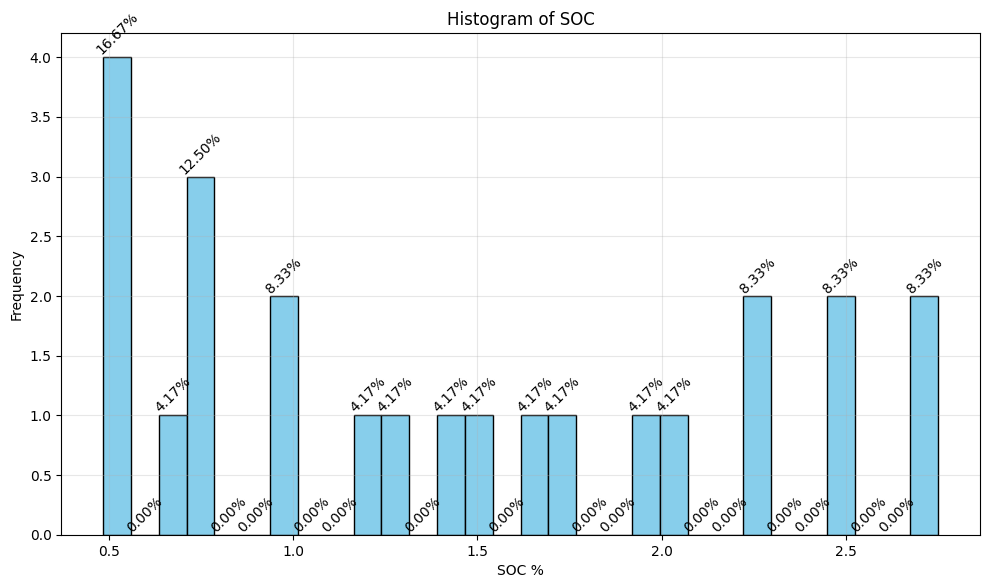

In [32]:
## Plot histogram of SOC ##
# Remove non-finite values 
filtered_data = raw_FD['SOC_pct'].replace([np.inf, -np.inf], np.nan).dropna()

# Choose realistic limits for the range
min_val = filtered_data.min()
max_val = filtered_data.max()

# Create histogram using matplotlib
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(filtered_data, bins=30, range=(min_val, max_val), 
                               color='skyblue', edgecolor='black')

# Calculate percentages
percentages = (counts / counts.sum()) * 100
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Add percentage labels above each bar
for i in range(len(counts)):
    plt.text(bin_centers[i], counts[i], f'{percentages[i]:.2f}%', 
             ha='center', va='bottom', rotation=45)

# Customize layout
plt.title('Histogram of SOC')
plt.xlabel('SOC %')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Show plot
plt.tight_layout()
plt.show()

### Von Haden data treatment

In [33]:
# Check input for basic errors ----
required_colnames = ["ID", "Ref_ID", "Rep", "Upper_cm", "Lower_cm",
                     "SOC_pct", "SOM_pct", "BD_g_cm3"]

# Initialize error flag
is_error = False

# Check if all required columns exist in the dataframe
if not all(col in raw_FD.columns for col in required_colnames):
    is_error = True
    raise ValueError("Missing or misspelled column name(s)")

# Check for missing values in ID fields
if raw_FD[["ID", "Ref_ID", "Rep"]].isna().any().any():
    is_error = True
    raise ValueError("Missing ID, Rep, or Ref_ID values")

# Check for missing values in depth measurements
if raw_FD[["Upper_cm", "Lower_cm"]].isna().any().any():
    is_error = True
    raise ValueError("Missing Upper_cm or Lower_cm values")

# Verify that numeric columns contain only numeric values
if not all(pd.api.types.is_numeric_dtype(raw_FD[col]) for col in ["Upper_cm", "Lower_cm", "SOC_pct", "BD_g_cm3", "SOM_pct"]):
    is_error = True
    raise ValueError("Non-numeric Upper_cm, Lower_cm, SOC_pct, BD_g_cm3, or SOM_pct values")

In [34]:
# Check the dataset tail
raw_FD.tail()

,ID,Rep,Ref_ID,Upper_cm,Lower_cm,SOC_pct,SOM_pct,BD_g_cm3
19,Y5_T1_P1_S2,1,Y0_T1_P1_S2,50,100,0.744093,1.282919,1.453574
20,Y5_T1_P1_S3,1,Y0_T1_P1_S3,0,10,2.237329,3.857463,1.470258
21,Y5_T1_P1_S3,1,Y0_T1_P1_S3,10,30,1.682550,2.900948,1.369262
22,Y5_T1_P1_S3,1,Y0_T1_P1_S3,30,50,0.695248,1.198703,1.459242
23,Y5_T1_P1_S3,1,Y0_T1_P1_S3,50,100,0.521180,0.898586,1.553420


In [35]:
# Stop script if there is an error with the input file ----
if is_error:
    raise Warning("ESM script has failed due to error(s) listed above")

else:
    # Begin processing input file ----
    # Remove extra columns and add FD type
    reduced_FD = raw_FD[["ID", "Rep", "Ref_ID", "Upper_cm", "Lower_cm",
                            "SOC_pct", "SOM_pct", "BD_g_cm3"]]
    reduced_FD["Type"] = "FD"

    # Order columns
    reduced_FD = reduced_FD[["Type", "ID", "Rep", "Ref_ID", "Upper_cm",
                                "Lower_cm", "SOC_pct", "SOM_pct", "BD_g_cm3"]]

    # Remove cores that do not have a surface (0 cm) sample
    filtered_FD = reduced_FD.groupby(["ID", "Rep"]).filter(lambda x: x["Upper_cm"].min() == 0)

    # Remove samples that have NAs
    filtered_FD = filtered_FD.dropna()

In [36]:
# Display the last few rows of the filtered_FD dataframe
filtered_FD.tail()

,Type,ID,Rep,Ref_ID,Upper_cm,Lower_cm,SOC_pct,SOM_pct,BD_g_cm3
19,FD,Y5_T1_P1_S2,1,Y0_T1_P1_S2,50,100,0.744093,1.282919,1.453574
20,FD,Y5_T1_P1_S3,1,Y0_T1_P1_S3,0,10,2.237329,3.857463,1.470258
21,FD,Y5_T1_P1_S3,1,Y0_T1_P1_S3,10,30,1.682550,2.900948,1.369262
22,FD,Y5_T1_P1_S3,1,Y0_T1_P1_S3,30,50,0.695248,1.198703,1.459242
23,FD,Y5_T1_P1_S3,1,Y0_T1_P1_S3,50,100,0.521180,0.898586,1.553420


In [37]:
# Display the last few rows of the reduced_FD dataframe
reduced_FD.tail()

,Type,ID,Rep,Ref_ID,Upper_cm,Lower_cm,SOC_pct,SOM_pct,BD_g_cm3
19,FD,Y5_T1_P1_S2,1,Y0_T1_P1_S2,50,100,0.744093,1.282919,1.453574
20,FD,Y5_T1_P1_S3,1,Y0_T1_P1_S3,0,10,2.237329,3.857463,1.470258
21,FD,Y5_T1_P1_S3,1,Y0_T1_P1_S3,10,30,1.682550,2.900948,1.369262
22,FD,Y5_T1_P1_S3,1,Y0_T1_P1_S3,30,50,0.695248,1.198703,1.459242
23,FD,Y5_T1_P1_S3,1,Y0_T1_P1_S3,50,100,0.521180,0.898586,1.553420


In [38]:
# Sort the filtered dataframe by ID, Rep, Upper_cm and Lower_cm columns
filtered_FD = filtered_FD.sort_values(by=["ID", "Rep", "Upper_cm", "Lower_cm"])

# Define functions equivalent to R code logic
def is_contiguous(group):
    # Shift Lower_cm values up by 1 row and fill first value with min Upper_cm
    # This allows comparison between Upper_cm and previous row's Lower_cm
    lower_cm_shifted = group["Lower_cm"].shift(1).fillna(group["Upper_cm"].min())
    # Check if all Upper_cm values match with shifted Lower_cm values
    return all(group["Upper_cm"].values == lower_cm_shifted.values)

def remove_below_noncontiguous(group):
    # Shift Lower_cm values up by 1 row and fill first value with min Upper_cm
    lower_cm_shifted = group["Lower_cm"].shift(1).fillna(group["Upper_cm"].min())
    # Find indices where Upper_cm doesn't match shifted Lower_cm (non-contiguous)
    noncontiguous_index = np.where(group["Upper_cm"].values != lower_cm_shifted.values)[0]
    if len(noncontiguous_index) > 0:
        # If non-contiguous points exist, keep only rows up to first non-contiguous point
        first_noncontiguous_index = noncontiguous_index[0]
        return group.iloc[:first_noncontiguous_index + 1]
    else:
        # If all points are contiguous, return entire group
        return group

# Apply functions to identify contiguous and non-contiguous intervals
all_contiguous_FD = filtered_FD.groupby(["ID", "Rep"]).filter(is_contiguous)
noncontiguous_FD = filtered_FD.groupby(["ID", "Rep"]).filter(lambda x: not is_contiguous(x))

# Remove samples below non-contiguous points
removed_noncontiguous_FD = noncontiguous_FD.groupby(["ID", "Rep"]).apply(remove_below_noncontiguous).reset_index(drop=True)

# Combine the filtered data
filtered_FD = pd.concat([all_contiguous_FD, removed_noncontiguous_FD]).reset_index(drop=True)

# Remove cores that do not have a sample deeper than min_core_length_cm
min_core_length_cm = 0
filtered_FD = filtered_FD.groupby(["ID", "Rep"]).filter(lambda x: x["Lower_cm"].max() >= min_core_length_cm)

/var/folders/qx/vq9z0lxj001g33kqy_6fsygc0000gq/T/ipykernel_64797/66767257.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  removed_noncontiguous_FD = noncontiguous_FD.groupby(["ID", "Rep"]).apply(remove_below_noncontiguous).reset_index(drop=True)


In [39]:
# Display the last few rows of the filtered_FD dataframe
filtered_FD.tail()

,Type,ID,Rep,Ref_ID,Upper_cm,Lower_cm,SOC_pct,SOM_pct,BD_g_cm3
19,FD,Y5_T1_P1_S2,1,Y0_T1_P1_S2,50,100,0.744093,1.282919,1.453574
20,FD,Y5_T1_P1_S3,1,Y0_T1_P1_S3,0,10,2.237329,3.857463,1.470258
21,FD,Y5_T1_P1_S3,1,Y0_T1_P1_S3,10,30,1.682550,2.900948,1.369262
22,FD,Y5_T1_P1_S3,1,Y0_T1_P1_S3,30,50,0.695248,1.198703,1.459242
23,FD,Y5_T1_P1_S3,1,Y0_T1_P1_S3,50,100,0.521180,0.898586,1.553420


In [40]:
#%%time
# Add in zero masses at zero cm (for interpolation of first interval)
def add_zero_masses(group):
    zero_mass = pd.DataFrame({
        "Type": ["FD"],
        "ID": [group["ID"].iloc[0]],
        "Rep": [group["Rep"].iloc[0]],
        "Ref_ID": [group["Ref_ID"].iloc[0]],
        "Upper_cm": [0],
        "Lower_cm": [0],
        "SOC_pct":  [0],
        "SOM_pct":  [0],
        "BD_g_cm3": [0]
    })
    return pd.concat([zero_mass, group])

# Group data by ID, Rep, and Ref_ID columns and apply add_zero_masses function to add zero mass values
# where measurements are missing, then reset the index dropping the old one
zero_masses_added = filtered_FD.groupby(["ID", "Rep", "Ref_ID"]).apply(add_zero_masses).reset_index(drop=True)

# Sort and reset index
modified_FD = zero_masses_added.sort_values(by=["ID", "Ref_ID", "Rep", "Upper_cm", "Lower_cm"]).reset_index(drop=True)

# Begin FD-based calculations ----
# Calculate soil mass in each interval
modified_FD["Soil_g_cm2"] = (modified_FD["Lower_cm"] - modified_FD["Upper_cm"]) * modified_FD["BD_g_cm3"]

# Calculate SOC mass in each interval
modified_FD["SOC_g_cm2"] = (modified_FD["SOC_pct"] / 100) * modified_FD["Soil_g_cm2"]

# Calculate SOM mass in each interval
modified_FD["SOM_g_cm2"] = (modified_FD["SOM_pct"] / 100) * modified_FD["Soil_g_cm2"]

# Calculate mineral soil mass in each interval
modified_FD["Min_Soil_g_cm2"] = modified_FD["Soil_g_cm2"] - modified_FD["SOM_g_cm2"]

/var/folders/qx/vq9z0lxj001g33kqy_6fsygc0000gq/T/ipykernel_64797/3058208450.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  zero_masses_added = filtered_FD.groupby(["ID", "Rep", "Ref_ID"]).apply(add_zero_masses).reset_index(drop=True)


In [41]:
# Display the last few rows of the dataframe
modified_FD.tail()

,Type,ID,Rep,Ref_ID,Upper_cm,Lower_cm,SOC_pct,SOM_pct,BD_g_cm3,Soil_g_cm2,SOC_g_cm2,SOM_g_cm2,Min_Soil_g_cm2
25,FD,Y5_T1_P1_S3,1,Y0_T1_P1_S3,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
26,FD,Y5_T1_P1_S3,1,Y0_T1_P1_S3,0,10,2.237329,3.857463,1.470258,14.702583,0.328945,0.567147,14.135436
27,FD,Y5_T1_P1_S3,1,Y0_T1_P1_S3,10,30,1.682550,2.900948,1.369262,27.385250,0.460771,0.794432,26.590818
28,FD,Y5_T1_P1_S3,1,Y0_T1_P1_S3,30,50,0.695248,1.198703,1.459242,29.184842,0.202907,0.349840,28.835003
29,FD,Y5_T1_P1_S3,1,Y0_T1_P1_S3,50,100,0.521180,0.898586,1.553420,77.671018,0.404806,0.697941,76.973077


In [42]:
# Calculate cumulative masses
# Group data by ID and Rep columns, then for each group:
# Calculate cumulative sums of various soil measurements using pandas cumsum()
cumulative_FD = modified_FD.groupby(["ID", "Rep"]).apply(lambda x: x.assign(
    Cum_Soil_g_cm2 = x["Soil_g_cm2"].cumsum(),
    Cum_SOC_g_cm2 = x["SOC_g_cm2"].cumsum(),
    Cum_SOM_g_cm2 = x["SOM_g_cm2"].cumsum(),
    Cum_Min_Soil_g_cm2 = x["Min_Soil_g_cm2"].cumsum()
)).reset_index(drop=True)  # Add reset_index to remove multiindex

/var/folders/qx/vq9z0lxj001g33kqy_6fsygc0000gq/T/ipykernel_64797/4179863030.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cumulative_FD = modified_FD.groupby(["ID", "Rep"]).apply(lambda x: x.assign(


In [43]:
# Check the final type of each column. 
cumulative_FD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Type                30 non-null     object 
 1   ID                  30 non-null     object 
 2   Rep                 30 non-null     int64  
 3   Ref_ID              30 non-null     object 
 4   Upper_cm            30 non-null     int64  
 5   Lower_cm            30 non-null     int64  
 6   SOC_pct             30 non-null     float64
 7   SOM_pct             30 non-null     float64
 8   BD_g_cm3            30 non-null     float64
 9   Soil_g_cm2          30 non-null     float64
 10  SOC_g_cm2           30 non-null     float64
 11  SOM_g_cm2           30 non-null     float64
 12  Min_Soil_g_cm2      30 non-null     float64
 13  Cum_Soil_g_cm2      30 non-null     float64
 14  Cum_SOC_g_cm2       30 non-null     float64
 15  Cum_SOM_g_cm2       30 non-null     float64
 16  Cum_Min_So

In [44]:
# Check the last 5 rows 
cumulative_FD.tail()

,Type,ID,Rep,Ref_ID,Upper_cm,Lower_cm,SOC_pct,SOM_pct,BD_g_cm3,Soil_g_cm2,SOC_g_cm2,SOM_g_cm2,Min_Soil_g_cm2,Cum_Soil_g_cm2,Cum_SOC_g_cm2,Cum_SOM_g_cm2,Cum_Min_Soil_g_cm2
25,FD,Y5_T1_P1_S3,1,Y0_T1_P1_S3,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
26,FD,Y5_T1_P1_S3,1,Y0_T1_P1_S3,0,10,2.237329,3.857463,1.470258,14.702583,0.328945,0.567147,14.135436,14.702583,0.328945,0.567147,14.135436
27,FD,Y5_T1_P1_S3,1,Y0_T1_P1_S3,10,30,1.682550,2.900948,1.369262,27.385250,0.460771,0.794432,26.590818,42.087832,0.789716,1.361579,40.726254
28,FD,Y5_T1_P1_S3,1,Y0_T1_P1_S3,30,50,0.695248,1.198703,1.459242,29.184842,0.202907,0.349840,28.835003,71.272675,0.992623,1.711418,69.561256
29,FD,Y5_T1_P1_S3,1,Y0_T1_P1_S3,50,100,0.521180,0.898586,1.553420,77.671018,0.404806,0.697941,76.973077,148.943692,1.397428,2.409359,146.534333


### Correction of SOC% and Soil Bulk Density based on equivalent soil mass using cubic spline regression

In [45]:
# This code implements Equivalent Soil Mass (ESM) calculations for soil organic carbon (SOC) data.
# Key components and workflow:

# 1. Setup
# - Creates an empty DataFrame 'cumulative_ESM' to store results
# - Identifies unique combinations of ID, Ref_ID, and Rep from cumulative_FD
# - Uses tqdm for progress tracking during processing

## Progress Bar
# from tqdm import tqdm

# v3 
# Begin ESM-based calculations
cumulative_ESM = pd.DataFrame()
unique_vals = cumulative_FD[["ID", "Ref_ID", "Rep"]].drop_duplicates()

# Initialize progress bar
progress_bar = tqdm(total=len(unique_vals), desc="Processing")

# 2. Main Processing Loop
# For each unique soil profile:
# - Extracts current sample data and reference data
# - Averages reference values by depth
# - Filters reference depths based on ESM_depths_cm
# - Handles extrapolation based on configuration:
#   * If extrapolation=False: limits to sample's maximum mineral mass
#   * If extrapolation=True: limits to sample's maximum depth

for i, current_vals in unique_vals.iterrows():
    
    current_Rep = cumulative_FD[(cumulative_FD["ID"] == current_vals["ID"]) &
                                (cumulative_FD["Ref_ID"] == current_vals["Ref_ID"]) &
                                (cumulative_FD["Rep"] == current_vals["Rep"])]
    # Subset the reference set of values
    current_refs = cumulative_FD[cumulative_FD["ID"] == current_vals["Ref_ID"]]
    
    # Average the reference values (in case of multiple values per depth)
    numeric_cols = ["Cum_Min_Soil_g_cm2", "Cum_SOC_g_cm2", "Cum_SOM_g_cm2", 
                   "SOC_pct", "SOM_pct", "BD_g_cm3", "Soil_g_cm2", 
                   "SOC_g_cm2", "SOM_g_cm2", "Min_Soil_g_cm2", "Cum_Soil_g_cm2"]
    
    current_refs_mean = (current_refs
        .groupby(["Upper_cm", "Lower_cm"])[numeric_cols]
        .mean()
        .reset_index())
    
    current_refs_mean = current_refs_mean[current_refs_mean["Lower_cm"].isin(ESM_depths_cm)]
    current_refs_mean["ID"] = current_vals["ID"]
    current_refs_mean["Ref_ID"] = current_vals["Ref_ID"]
    current_refs_mean["Rep"] = current_vals["Rep"]
    current_refs_mean["Type"] = "ESM"
    
    # Determine whether extrapolation outside of maximum mass occurs
    if not extrapolation:
        # Remove references where mineral mass is greater than the sample max
        # Completely avoids extrapolation outside of spline model
        current_refs_filtered = current_refs_mean[current_refs_mean["Cum_Min_Soil_g_cm2"] <= current_Rep["Cum_Min_Soil_g_cm2"].max()]
    else:
        # Remove references that have a depth greater than sample max
        # Extrapolates only to the maximum depth of the samples
        current_refs_filtered = current_refs_mean[current_refs_mean["Lower_cm"] <= current_Rep["Lower_cm"].max()]

    # 3. Spline Interpolation
    # - Creates cubic spline models for SOC and SOM using scipy.interpolate.CubicSpline
    # - Uses mineral soil mass as independent variable
    # - Interpolates cumulative SOC and SOM values at reference depths
    
    try:
        spline_SOC = CubicSpline(current_Rep["Cum_Min_Soil_g_cm2"], current_Rep["Cum_SOC_g_cm2"], bc_type='not-a-knot')
        spline_SOM = CubicSpline(current_Rep["Cum_Min_Soil_g_cm2"], current_Rep["Cum_SOM_g_cm2"], bc_type='not-a-knot') 

    except ValueError as e:
        print(f"Skipping iteration {i} due to error: {e}. ID={current_Rep.ID.unique()[0]}")
        progress_bar.update(1)
        continue
    
    current_refs_filtered["Cum_SOC_g_cm2"] = spline_SOC(current_refs_filtered["Cum_Min_Soil_g_cm2"])
    current_refs_filtered["Cum_SOM_g_cm2"] = spline_SOM(current_refs_filtered["Cum_Min_Soil_g_cm2"]) 

    # 4. Mass Calculations
    # - Calculates non-cumulative masses using differences
    # - Computes derived values:
    #   * Bulk density (BD)
    #   * SOC and SOM percentages
    #   * Total soil mass
    #   * Cumulative soil mass

    # Calculate non-cumulative masses using .diff() directly on the DataFrame
    current_refs_filtered["Min_Soil_g_cm2"] = current_refs_filtered["Cum_Min_Soil_g_cm2"].diff().fillna(current_refs_filtered["Cum_Min_Soil_g_cm2"])
    current_refs_filtered["SOC_g_cm2"] = current_refs_filtered["Cum_SOC_g_cm2"].diff().fillna(current_refs_filtered["Cum_SOC_g_cm2"])
    current_refs_filtered["SOM_g_cm2"] = current_refs_filtered["Cum_SOM_g_cm2"].diff().fillna(current_refs_filtered["Cum_SOM_g_cm2"])

    # Additional Calculations
    current_refs_filtered["Soil_g_cm2"] = current_refs_filtered["Min_Soil_g_cm2"] + current_refs_filtered["SOM_g_cm2"]
    current_refs_filtered["BD_g_cm3"] = current_refs_filtered["Soil_g_cm2"] / (current_refs_filtered["Lower_cm"] - current_refs_filtered["Upper_cm"])
    current_refs_filtered["SOC_pct"] = current_refs_filtered["SOC_g_cm2"] / current_refs_filtered["Soil_g_cm2"] * 100
    current_refs_filtered["SOM_pct"] = current_refs_filtered["SOM_g_cm2"] / current_refs_filtered["Soil_g_cm2"] * 100
    current_refs_filtered["Cum_Soil_g_cm2"] = current_refs_filtered["Soil_g_cm2"].cumsum()

    # Append to the cumulative_ESM DataFrame
    cumulative_ESM = pd.concat([cumulative_ESM, current_refs_filtered])

    # Update progress bar
    progress_bar.update(1)

# Close progress bar
progress_bar.close()

# 5. Post-processing
# - Removes zero-depth entries
# - Standardizes column ordering between FD and ESM datasets
# - Resets index for final output

# Post-processing cleanup and output
cumulative_FD = cumulative_FD[~((cumulative_FD["Upper_cm"] == 0) & (cumulative_FD["Lower_cm"] == 0))]
cumulative_ESM = cumulative_ESM[~((cumulative_ESM["Upper_cm"] == 0) & (cumulative_ESM["Lower_cm"] == 0))]

# Add NA for FD reference ID
cumulative_FD["Ref_ID"] = np.nan

# Re-order column names in ESM dataset
cumulative_ESM = cumulative_ESM[cumulative_FD.columns]
cumulative_ESM = cumulative_ESM.reset_index(drop=True)

Processing: 100%|██████████| 6/6 [00:00<00:00, 101.88it/s]


In [46]:
cumulative_ESM.tail(1)

,Type,ID,Rep,Ref_ID,Upper_cm,Lower_cm,SOC_pct,SOM_pct,BD_g_cm3,Soil_g_cm2,SOC_g_cm2,SOM_g_cm2,Min_Soil_g_cm2,Cum_Soil_g_cm2,Cum_SOC_g_cm2,Cum_SOM_g_cm2,Cum_Min_Soil_g_cm2
23,ESM,Y5_T1_P1_S3,1,Y0_T1_P1_S3,50,100,0.484117,0.834685,1.550339,77.516947,0.375273,0.647022,76.869924,146.544239,1.360401,2.345519,144.198721


In [47]:
cumulative_FD.tail(1)

,Type,ID,Rep,Ref_ID,Upper_cm,Lower_cm,SOC_pct,SOM_pct,BD_g_cm3,Soil_g_cm2,SOC_g_cm2,SOM_g_cm2,Min_Soil_g_cm2,Cum_Soil_g_cm2,Cum_SOC_g_cm2,Cum_SOM_g_cm2,Cum_Min_Soil_g_cm2
29,FD,Y5_T1_P1_S3,1,NaN,50,100,0.52118,0.898586,1.55342,77.671018,0.404806,0.697941,76.973077,148.943692,1.397428,2.409359,146.534333


In [48]:
raw_FD.head(1)

,ID,Rep,Ref_ID,Upper_cm,Lower_cm,SOC_pct,SOM_pct,BD_g_cm3
0,Y0_T1_P1_S1,1,Y0_T1_P1_S1,0,10,2.500134,4.310575,1.250032


In [49]:
#Converting from SOC (%) to SOC(ton/ha)[stock]
#Stock of carbon
cumulative_FD['SOC_ton_ha'] =(cumulative_FD['Lower_cm']-cumulative_FD['Upper_cm'])*cumulative_FD['BD_g_cm3']*cumulative_FD['SOC_pct']
cumulative_ESM['SOC_ton_ha']=(cumulative_ESM['Lower_cm']-cumulative_ESM['Upper_cm'])*cumulative_ESM['BD_g_cm3']*cumulative_ESM['SOC_pct']

#Converting from SOC (%) to SOC(ton/ha)[stock cumulative]. SOC(g/cm2) to SOC ton/ha: SOC(g/cm2) * 100. 
#Stock of carbon
cumulative_FD['SOC_ton_acum'] =cumulative_FD['Cum_SOC_g_cm2']*100
cumulative_ESM['SOC_ton_acum']=cumulative_ESM['Cum_SOC_g_cm2']*100

In [50]:
cumulative_FD.tail(1)

,Type,ID,Rep,Ref_ID,Upper_cm,Lower_cm,SOC_pct,SOM_pct,BD_g_cm3,Soil_g_cm2,SOC_g_cm2,SOM_g_cm2,Min_Soil_g_cm2,Cum_Soil_g_cm2,Cum_SOC_g_cm2,Cum_SOM_g_cm2,Cum_Min_Soil_g_cm2,SOC_ton_ha,SOC_ton_acum
29,FD,Y5_T1_P1_S3,1,NaN,50,100,0.52118,0.898586,1.55342,77.671018,0.404806,0.697941,76.973077,148.943692,1.397428,2.409359,146.534333,40.480572,139.742834


In [51]:
# Export to excel file. 
with pd.ExcelWriter(output_filename) as writer:
    cumulative_FD.to_excel(writer, sheet_name="FD", index=False)
    cumulative_ESM.to_excel(writer, sheet_name="ESM", index=False)

### Visual Difference of SOC and Bulk Density corrected vs non-Corrected with Equivalent Soil Mass 

In [52]:
cumulative_FD.columns

Index(['Type', 'ID', 'Rep', 'Ref_ID', 'Upper_cm', 'Lower_cm', 'SOC_pct',
       'SOM_pct', 'BD_g_cm3', 'Soil_g_cm2', 'SOC_g_cm2', 'SOM_g_cm2',
       'Min_Soil_g_cm2', 'Cum_Soil_g_cm2', 'Cum_SOC_g_cm2', 'Cum_SOM_g_cm2',
       'Cum_Min_Soil_g_cm2', 'SOC_ton_ha', 'SOC_ton_acum'],
      dtype='object')

In [53]:
#Compare the stock with and without correction 
#FD
FD = cumulative_FD[[
    'ID','Upper_cm','Lower_cm','SOC_ton_ha','BD_g_cm3','SOC_pct']]
FD = FD.rename(columns={'SOC_ton_ha':'SOC_ton_ha_FD',
                        'BD_g_cm3':'BD_g_cm3_FD',
                        'SOC_pct':'SOC_pct_FD'
                        })
#ESM
ESM = cumulative_ESM[[
    'ID','Ref_ID','Upper_cm','Lower_cm','SOC_ton_ha','BD_g_cm3','SOC_pct']]
ESM = ESM.rename(columns={'SOC_ton_ha':'SOC_ton_ha_ESM', 
                          'Ref_ID':'Ref_ID_ESM',
                          'BD_g_cm3':'BD_g_cm3_ESM',
                           'SOC_pct':'SOC_pct_ESM'
                          })
#merge datasets of stock
ESM_FD_stock = pd.merge(FD,ESM,how='right',on=['ID','Upper_cm','Lower_cm'])

# Change the columns order
ESM_FD_stock = ESM_FD_stock[['ID','Ref_ID_ESM','Upper_cm','Lower_cm',
                             'SOC_pct_FD','SOC_pct_ESM',
                             'BD_g_cm3_FD','BD_g_cm3_ESM','SOC_ton_ha_FD','SOC_ton_ha_ESM']]

#Add columns is_SOC_corrected 
ESM_FD_stock['is_SOC_corrected'] = np.where(ESM_FD_stock['ID'] == ESM_FD_stock['Ref_ID_ESM'],'no','yes')

In [54]:
ESM_FD_stock.tail(2)

,ID,Ref_ID_ESM,Upper_cm,Lower_cm,SOC_pct_FD,SOC_pct_ESM,BD_g_cm3_FD,BD_g_cm3_ESM,SOC_ton_ha_FD,SOC_ton_ha_ESM,is_SOC_corrected
22,Y5_T1_P1_S3,Y0_T1_P1_S3,30,50,0.695248,0.762039,1.459242,1.450715,20.290699,22.110034,yes
23,Y5_T1_P1_S3,Y0_T1_P1_S3,50,100,0.521180,0.484117,1.553420,1.550339,40.480572,37.527304,yes


In [55]:
### Looking for outliers at the soil corrected density

In [56]:
#Calculate delta fixed depth (FD) x equivalent soil mass (ESM)
# ratio stock 
ESM_FD_stock['ratio_stock_FD_ESM'] = (ESM_FD_stock['SOC_ton_ha_FD']-ESM_FD_stock['SOC_ton_ha_ESM'])/ESM_FD_stock['SOC_ton_ha_FD']

# Dif density
ESM_FD_stock['dif_soil_density_FD_ESM'] = (ESM_FD_stock['BD_g_cm3_FD']-ESM_FD_stock['BD_g_cm3_ESM'])

#Create outlier label:
ESM_FD_stock['is_ratio_stock_FD_ESM_outlier'] = np.where(abs(ESM_FD_stock['ratio_stock_FD_ESM']) > 1 ,'yes','no')

array([[<Axes: title={'center': 'BD_g_cm3_FD'}>,
        <Axes: title={'center': 'BD_g_cm3_ESM'}>]], dtype=object)

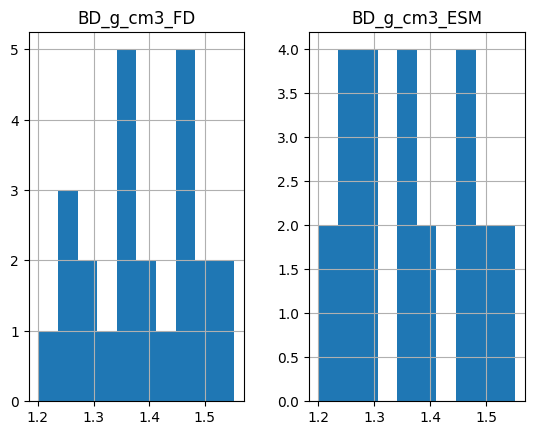

In [57]:
ESM_FD_stock[['BD_g_cm3_FD','BD_g_cm3_ESM']].hist()

array([[<Axes: title={'center': 'SOC_ton_ha_FD'}>,
        <Axes: title={'center': 'SOC_ton_ha_ESM'}>]], dtype=object)

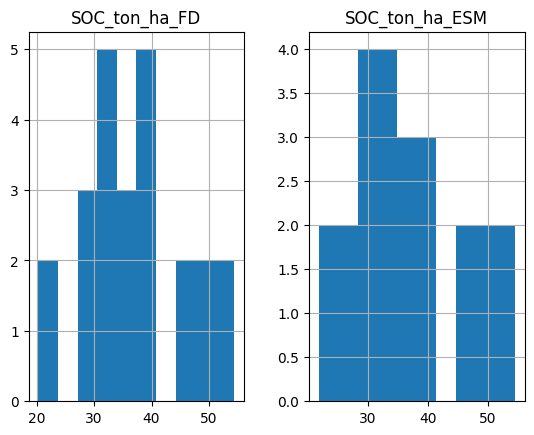

In [58]:
ESM_FD_stock[['SOC_ton_ha_FD','SOC_ton_ha_ESM']].hist()

<Axes: >

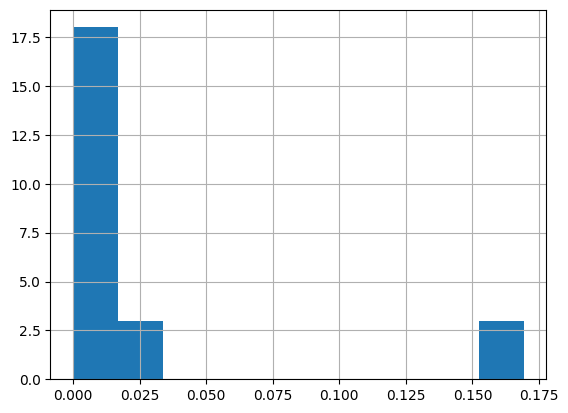

In [59]:
#Histogram of Delta fixed depth (FD) x equivalent soil mass (ESM)
ESM_FD_stock['dif_soil_density_FD_ESM'].hist()

In [60]:
ESM_FD_stock.shape

(24, 14)

Values of SOC ton/ha: (FD-ESM/FD) bigger than 1 or -1 are probably outliers of SOC or BD estimation with ESM


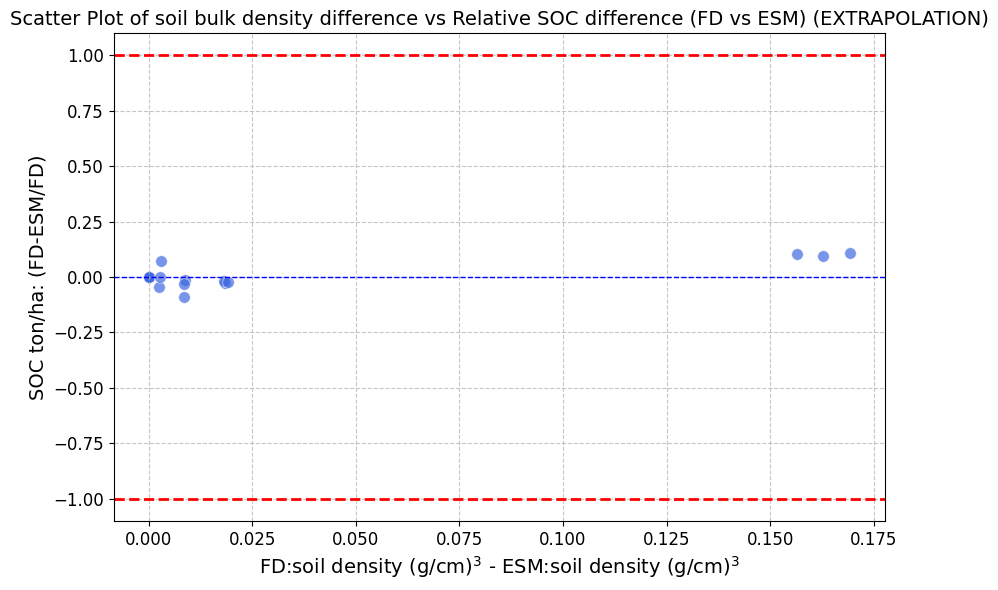

In [61]:
# Plot Scatter plot of standardized data
print("Values of SOC ton/ha: (FD-ESM/FD) bigger than 1 or -1 are probably outliers of SOC or BD estimation with ESM")

# Assuming ESM_FD_stock is already defined
# Extract variables
X = ESM_FD_stock['dif_soil_density_FD_ESM'].values
y = ESM_FD_stock['ratio_stock_FD_ESM'].values

# Create a larger figure
plt.figure(figsize=(9, 6))

# Create a scatter plot
plt.scatter(X, y, facecolor='royalblue', edgecolor='white', linewidth=0.5, s=70, alpha=0.7, label='Data point: ID/depth')

# Add red dashed lines at y=+1 and y=-1
plt.axhline(y=1, color='red', linestyle='--', linewidth=2)
plt.axhline(y=-1, color='red', linestyle='--', linewidth=2)
plt.axhline(y=0, color='blue', linestyle='--', linewidth=1)

# Add title and labels with increased font size
plt.title('Scatter Plot of soil bulk density difference vs Relative SOC difference (FD vs ESM) (EXTRAPOLATION)', fontsize=14)
plt.xlabel('FD:soil density (g/cm)$^3$ - ESM:soil density (g/cm)$^3$', fontsize=14)
plt.ylabel('SOC ton/ha: (FD-ESM/FD)', fontsize=14)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Use scientific notation for y-axis if numbers are very small
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


### END of analysis ###